In [3]:
!pip install transformers

In [4]:
#https://www.kaggle.com/crowdflower/twitter-airline-sentiment
#!wget -nc https://lazyprogrammer.me/course_files/AirelineTweets.csv

In [5]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os # accessing directory structure

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

c:\Users\joshu\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [31]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [30]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [11]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Tweets.csv has 14640 rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('datastore\Tweets.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'Tweets.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 15 columns


In [12]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
df = df[['airline_sentiment', 'text']].copy()

<AxesSubplot:>

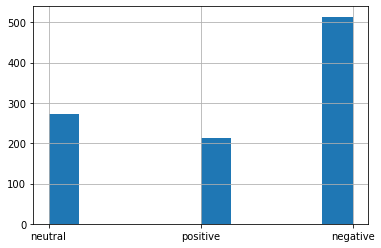

In [14]:
df['airline_sentiment'].hist()

In [15]:
#Filter out rows that have been set as neutral
df = df[df.airline_sentiment != 'neutral'].copy()

In [16]:
#Map labels to integers, could be useful later. start dict and pass in mapping we just created and assign to new column target
target_map = {'positive' : 1, 'negative': 0 }
df['target'] = df['airline_sentiment'].map(target_map)

In [17]:
# See what dataframe looks like now, we have a target column coorsonding to if sentiment was positive or negative
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [18]:
#How many samples we have in dataframe
len(df)

728

In [19]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [20]:
#Use our pretrain classifier to get predictions, grab 
texts = df['text'].tolist()
predictions = classifier(texts)

In [21]:
predictions

[{'label': 'POSITIVE', 'score': 0.6070865392684937},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854251742362976},
 {'label': 'POSITIVE', 'score': 0.9553210139274597},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787648916244507},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [24]:
#Data is imbalance, probs must all be of the same kind, so we want them all to be for the positive class, we convert the negative class to positive class
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions]


In [25]:
#Print out the predictions, some are very small and close to zero
probs

[0.6070865392684937,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574825763702393,
 0.9553210139274597,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787648916244507,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.01542818546295166,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934479594230652,
 0.9976067543029785,
 0.8661726117134094,
 0.0003237724304199219,
 0.841560423374176,
 0.0032317638397216797,
 0.9997846484184265,
 0.17614644765853882,
 0.9993895292282104,
 0.09156584739685059,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.9911696910858154,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [26]:
#Get the labels, if the label starts with a P, we put a 1, else we put a 0
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [27]:
preds = np.array(preds) #cast list to a numpy array

In [28]:
print ("acc:", np.mean(df['target'] == preds)) #Get almost 90% accuracy, considering this model hasn't seen any tweets before

acc: 0.8901098901098901


In [29]:
cm = confusion_matrix(df['target'], preds, normalize='true') #used to evaluate the performance of a classification model.
cm

array([[0.91050584, 0.08949416],
       [0.1588785 , 0.8411215 ]])

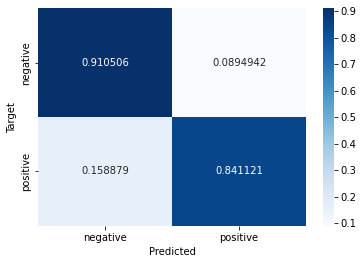

In [36]:
#Scikit-learn is transitioning to v1 but its not available in transformers yet, so we have to use the old version
#Use a pandas dataframe to plot the confusion matrix
def plot_cm(cm):
    classes = ['negative', 'positive'] #set the classes
    df_cm = pd.DataFrame(cm, index=classes, columns=classes) #create a pandas dataframe
    ax = sn.heatmap(df_cm, cmap='Blues', annot=True, fmt="g") #use seaborn to plot the heatmap
    ax.set_xlabel('Predicted') #set the x label
    ax.set_ylabel('Target') #set the y label

plot_cm(cm)

In [33]:
#Get the f1 score, which is a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
# f1 is the harmonic mean of precision and recall, depends on what we want to detect or what we want to retrieve
f1_score(df['target'], preds) 

0.8181818181818182

In [34]:
#Get the f1 score, which is a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
# if value was 1, we would have a perfect model, if value was 0, we would have a terrible model
f1_score(1 - df['target'], 1 - preds) 

0.921259842519685

In [37]:
#Get the roc auc score, which is the area under the curve of the receiver operating characteristic
# The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
# We get about 95% which is very good
roc_auc_score(df['target'], probs) 

0.9513345939852359

In [39]:
#Get the roc auc score, which is the area under the curve of the receiver operating characteristic
# We get 95% which is very good
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.9513345939852359